# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.16.2-alpha'

### Dataset preparation
Download the datasets to "input" direcotry and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()

### Start scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

In [6]:
# If you want to stop displaying figures when using interactive shell,
# snl.interactive = False
# For temporally, plese use snl.records(show_figure=False) etc.
# If you want save figures,
# snl.interactive = False
# and please use snl.records(filename="records.jpg") etc.

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

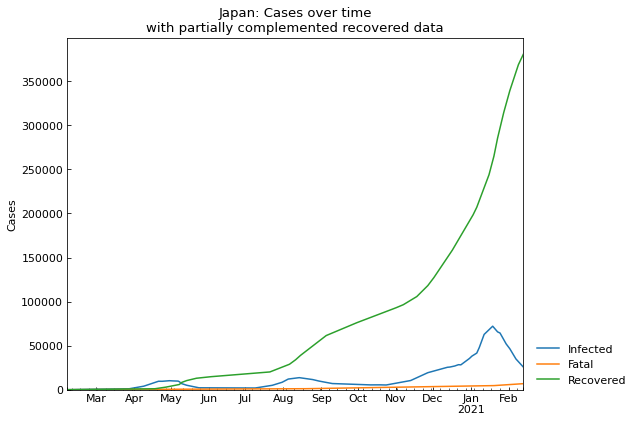

,Date,Infected,Fatal,Recovered
369,2021-02-09,31477,6476,368813
370,2021-02-10,29094,6557,372535
371,2021-02-11,27880,6678,375454
372,2021-02-12,26953,6774,378024
373,2021-02-13,25736,6849,380569


In [7]:
record_df = snl.records()
record_df.tail()

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

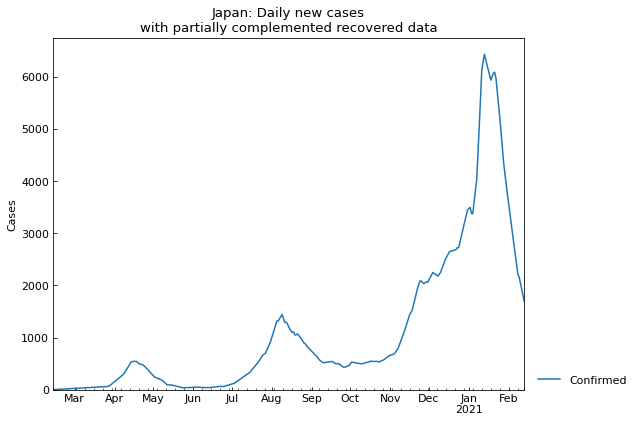

In [8]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

`Scenario.show_complement()` method is useful to show the kinds of complement. The details of complement are explained in [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html#The-number-of-cases-(JHU-style)) section.

In [9]:
complement_snl_df = snl.show_complement()
complement_snl_df.tail()

,Country,Province,Monotonic_confirmed,Monotonic_fatal,Monotonic_recovered,Full_recovered,Partial_recovered
0,Japan,-,False,False,True,False,True


### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

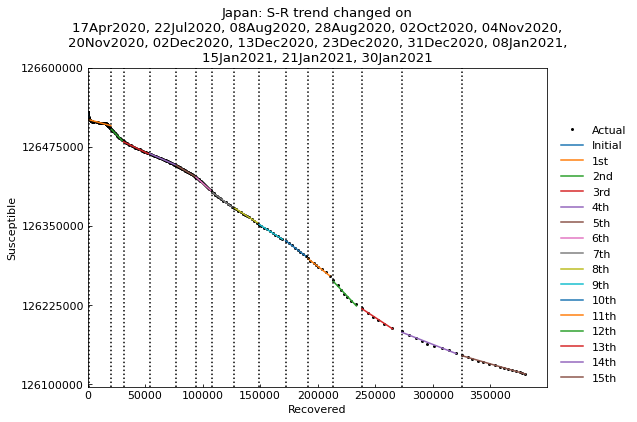

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,21Jul2020,126529100
2nd,Past,22Jul2020,07Aug2020,126529100
3rd,Past,08Aug2020,27Aug2020,126529100
4th,Past,28Aug2020,01Oct2020,126529100
5th,Past,02Oct2020,03Nov2020,126529100
6th,Past,04Nov2020,19Nov2020,126529100
7th,Past,20Nov2020,01Dec2020,126529100
8th,Past,02Dec2020,12Dec2020,126529100
9th,Past,13Dec2020,22Dec2020,126529100


In [10]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [11]:
# Estimate the parameter values of SIR-F model
# Default value of timeout is 180 sec
snl.estimate(cs.SIRF, timeout=60)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	15th phase (30Jan2021 - 13Feb2021): finished  589 trials in 0 min 30 sec


	 4th phase (28Aug2020 - 01Oct2020): finished  454 trials in 0 min 50 sec

	 0th phase (06Feb2020 - 16Apr2020): finished  443 trials in 0 min 50 sec

	 5th phase (02Oct2020 - 03Nov2020): finished  458 trials in 0 min 50 sec

	 3rd phase (08Aug2020 - 27Aug2020): finished  561 trials in 1 min  0 sec

	 2nd phase (22Jul2020 - 07Aug2020): finished  561 trials in 1 min  0 sec

	 1st phase (17Apr2020 - 21Jul2020): finished  495 trials in 1 min  0 sec

	 7th phase (20Nov2020 - 01Dec2020): finished  550 trials in 1 min  0 sec

	 6th phase (04Nov2020 - 19Nov2020): finished  549 trials in 1 min  0 sec

	10th phase (23Dec2020 - 30Dec2020): finished  212 trials in 0 min 20 sec

	11th phase (31Dec2020 - 07Jan2021): finished  214 trials in 0 min 20 sec

	13th phase (15Jan2021 - 20Jan2021): finished  217 trials in 0 min 20 sec

	 8th phase (02Dec2020 - 12Dec2020): finished  588 trials in 0 min 50 sec

	 9th phase (13Dec2020 - 22Dec2020): finished  596 trials in 0 min 50 sec

	12th phase (08Jan2021 - 14Jan2021): finished  669 trials in 0 min 50 sec

	14th phase (21Jan2021 - 29Jan2021): finished  671 trials in 0 min 50 sec

Completed optimization. Total: 2 min 23 sec


In [12]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,5.88,0.004084,0.000301,0.016946,0.002567,240,64,9,0.004,553,0.298703,443,0 min 50 sec
1st,Past,17Apr2020,21Jul2020,126529100,SIR-F,0.70,0.016372,0.000452,0.008489,0.011446,240,14,19,0.016,368,0.451897,495,1 min 0 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,1.87,0.000492,0.000096,0.023423,0.012409,240,13,7,0.000,1731,0.032899,561,1 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.95,0.000066,0.000152,0.012759,0.013318,240,12,13,0.000,1098,0.044222,561,1 min 0 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.74,0.016563,0.000046,0.011161,0.014795,240,11,14,0.017,3636,0.035958,454,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.05,0.005464,0.000180,0.019082,0.017832,240,9,8,0.005,925,0.057277,458,0 min 50 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.60,0.000079,0.000231,0.023921,0.014740,240,11,6,0.000,721,0.033932,549,1 min 0 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.40,0.002852,0.000059,0.019945,0.014143,240,11,8,0.003,2817,0.028664,550,1 min 0 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.16,0.000405,0.000256,0.018403,0.015552,240,10,9,0.000,650,0.007945,588,0 min 50 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.11,0.000623,0.000261,0.017494,0.015427,240,10,9,0.001,638,0.008458,596,0 min 50 sec


### Accuracy of estimation

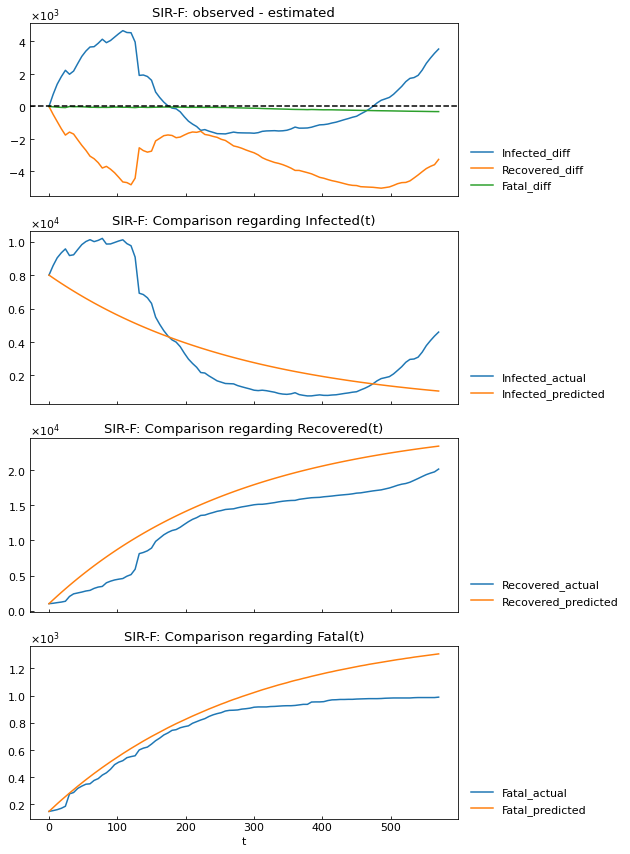

In [13]:
snl.estimate_accuracy(phase="1st")

### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [14]:
snl.get("Rt", phase="4th")

0.74

### Show parameter history
`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

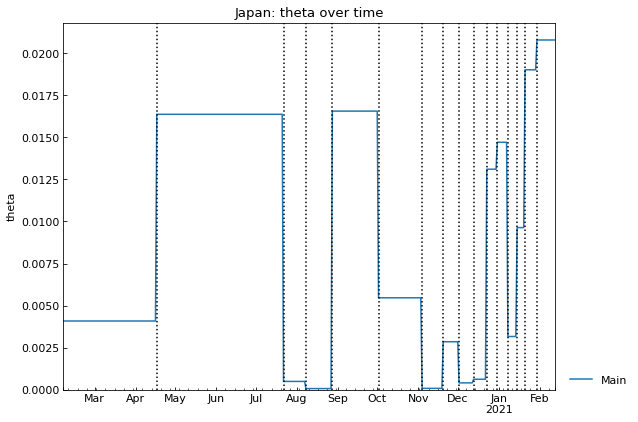

In [15]:
_ = snl.history(target="theta")

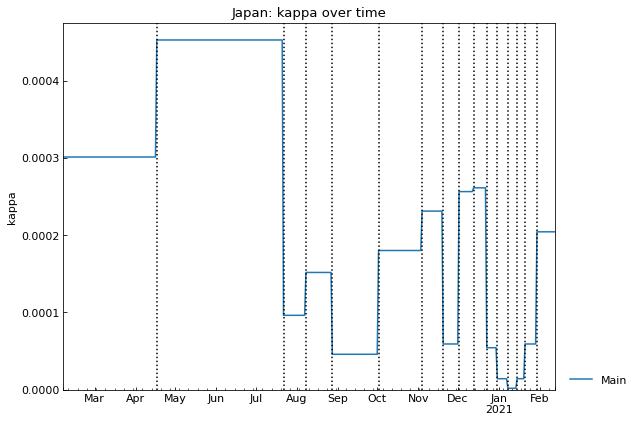

In [16]:
_ = snl.history(target="kappa")

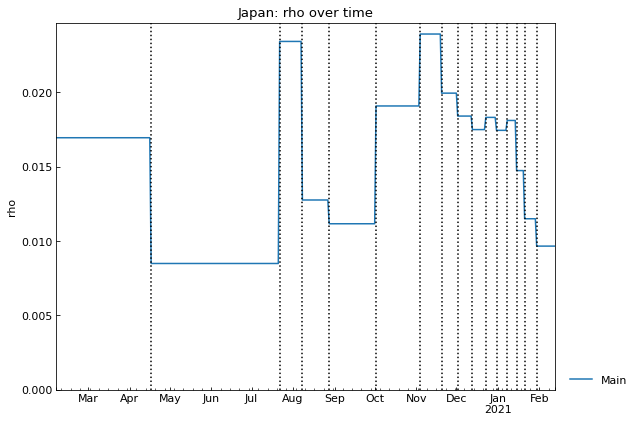

In [17]:
_ = snl.history(target="rho")

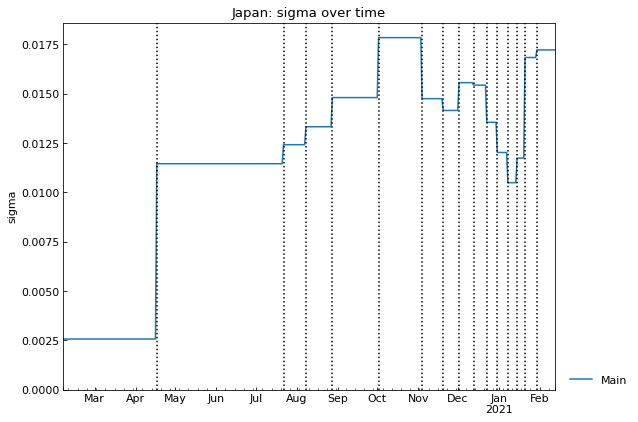

In [18]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

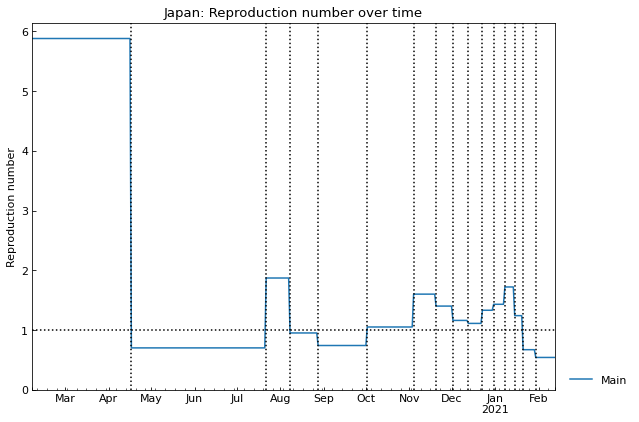

In [19]:
_ = snl.history(target="Rt")

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

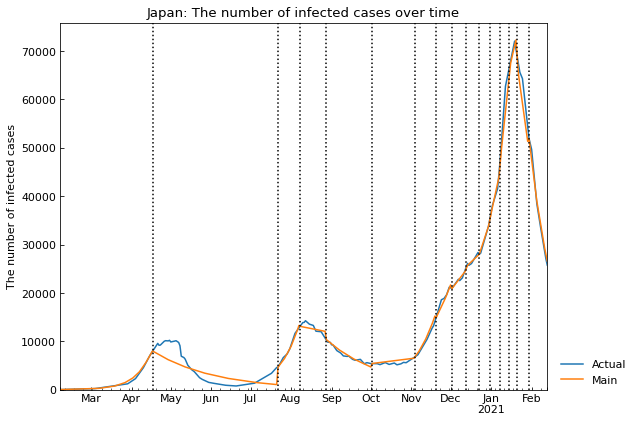

In [20]:
_ = snl.history("Infected")

### Main scenario
To investigate the effect of parameter changes, we will perform scenario analysis. In the main scenario, we will assume that the parameter values do not change after the last past phase.

i.e. If the parameter velues will not be changed until 01Apr2021, how many cases will be? We call this scenario as "Main" scenario.

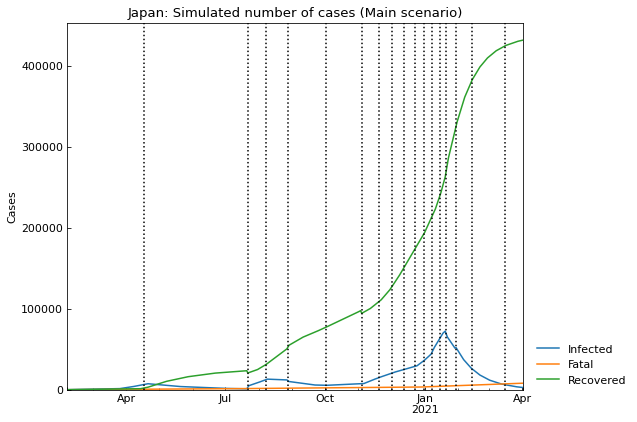

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,441789,8012,3228,430549
418,2021-03-30,441971,8020,3077,430874
419,2021-03-31,442144,8027,2933,431184
420,2021-04-01,442310,8034,2796,431480
421,2021-04-02,442468,8041,2665,431762


In [21]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30)
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Apr2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
To investigate the effect of new medicines, we will assume that $\sigma$ will be changed in the future phases.

If $\sigma$ will be double in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [22]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.017209486584665895

In [23]:
# Sigma value will be double
sigma_new = sigma_current * 2
sigma_new

0.03441897316933179

In [24]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Apr2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,5.88,0.004084,0.000301,0.016946,0.002567,240,64,9,0.004,553,0.298703,443,0 min 50 sec
1st,Past,17Apr2020,21Jul2020,126529100,SIR-F,0.70,0.016372,0.000452,0.008489,0.011446,240,14,19,0.016,368,0.451897,495,1 min 0 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,1.87,0.000492,0.000096,0.023423,0.012409,240,13,7,0.000,1731,0.0328993,561,1 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.95,0.000066,0.000152,0.012759,0.013318,240,12,13,0.000,1098,0.0442224,561,1 min 0 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.74,0.016563,0.000046,0.011161,0.014795,240,11,14,0.017,3636,0.0359582,454,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.05,0.005464,0.000180,0.019082,0.017832,240,9,8,0.005,925,0.0572766,458,0 min 50 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.60,0.000079,0.000231,0.023921,0.014740,240,11,6,0.000,721,0.0339322,549,1 min 0 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.40,0.002852,0.000059,0.019945,0.014143,240,11,8,0.003,2817,0.0286642,550,1 min 0 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.16,0.000405,0.000256,0.018403,0.015552,240,10,9,0.000,650,0.00794546,588,0 min 50 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.11,0.000623,0.000261,0.017494,0.015427,240,10,9,0.001,638,0.00845837,596,0 min 50 sec


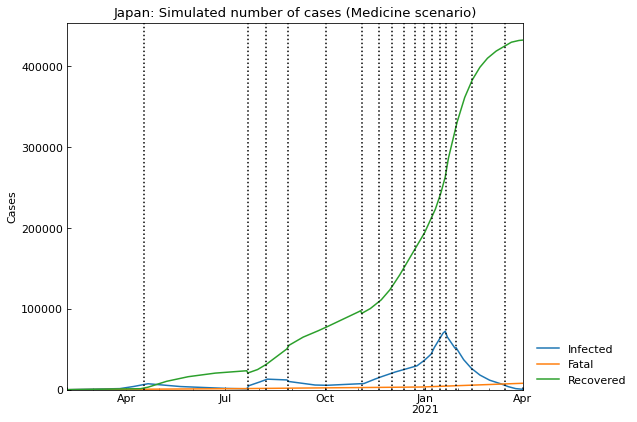

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,440402,7954,844,431604
418,2021-03-30,440448,7956,726,431766
419,2021-03-31,440487,7958,624,431905
420,2021-04-01,440520,7959,537,432024
421,2021-04-02,440549,7960,462,432127


In [25]:
# Simulate the number of cases
snl.simulate(name="Medicine").tail()

### Short-term prediction of parameter values
With OxCGRT data, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures) impact on parameter values with delay period (calculated with `cenario.estimate_delay()` with version > 2.15.0-beta or set as recovery period).  

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [26]:
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(oxcgrt_data=oxcgrt_data, name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']} (train)")
print(f"Determination coefficient: {fit_dict['score_test']} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)

Determination coefficient: 0.6296553309781686 (train)
Determination coefficient: 0.6113842252623136 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing
theta,0.000660,0.004079,-0.003903,0.000000,0.004548,0.008956,0.004079,0.002572,-0.001385,-0.012526,0.000000
kappa,0.000039,0.000040,-0.000041,0.000000,-0.000098,0.000120,0.000040,-0.000005,0.000007,-0.000319,0.000000
rho,-0.000794,-0.003161,0.002922,0.000000,0.000589,-0.005609,-0.003161,-0.002974,0.001745,0.009778,0.000000
sigma,-0.002404,0.002099,-0.002250,0.000000,0.000078,0.008150,0.002099,-0.000967,0.000857,0.003850,0.000000


In [27]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,5.88,0.004084,0.000301,0.016946,0.002567,240,64,9,0.004,553,0.298703,443,0 min 50 sec
1st,Past,17Apr2020,21Jul2020,126529100,SIR-F,0.70,0.016372,0.000452,0.008489,0.011446,240,14,19,0.016,368,0.451897,495,1 min 0 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,1.87,0.000492,0.000096,0.023423,0.012409,240,13,7,0.000,1731,0.0328993,561,1 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.95,0.000066,0.000152,0.012759,0.013318,240,12,13,0.000,1098,0.0442224,561,1 min 0 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.74,0.016563,0.000046,0.011161,0.014795,240,11,14,0.017,3636,0.0359582,454,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.05,0.005464,0.000180,0.019082,0.017832,240,9,8,0.005,925,0.0572766,458,0 min 50 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.60,0.000079,0.000231,0.023921,0.014740,240,11,6,0.000,721,0.0339322,549,1 min 0 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.40,0.002852,0.000059,0.019945,0.014143,240,11,8,0.003,2817,0.0286642,550,1 min 0 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.16,0.000405,0.000256,0.018403,0.015552,240,10,9,0.000,650,0.00794546,588,0 min 50 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.11,0.000623,0.000261,0.017494,0.015427,240,10,9,0.001,638,0.00845837,596,0 min 50 sec


In [28]:
# Or, when you do not need 'fit_dict'
# snl.fit_predict(oxcgrt_data=oxcgrt_data, name="Forecast").summary(name="Forecast")

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values. Currently, we can compare the scenarios with the following indexes.

- max(Infected): max value of Infected
- argmax(Infected): the date when Infected shows max value
- Infected on …: Infected on the end date of the last phase
- Fatal on …: Fatal on the end date of the last phase

In [29]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,Confirmed on 01Mar2021,Infected on 01Mar2021,Fatal on 01Mar2021,16th_Rt,17th_Rt
Main,72279,20Jan2021,442468.0,2665.0,8041.0,NaN,NaN,NaN,0.54,0.54
Medicine,72279,20Jan2021,440549.0,462.0,7960.0,NaN,NaN,NaN,0.54,0.27
Forecast,72279,20Jan2021,NaN,NaN,NaN,448656.0,26565.0,7512.0,1.04,-


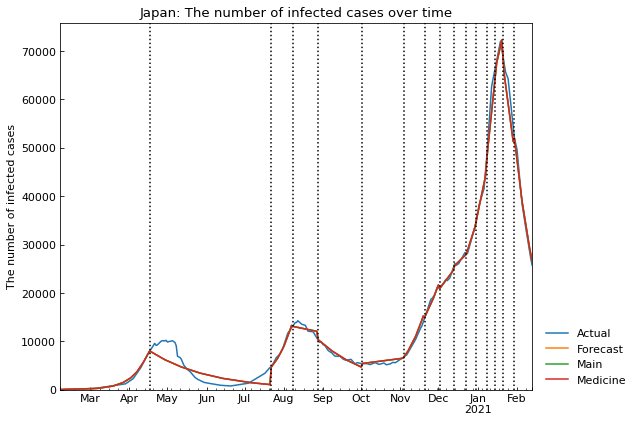

In [30]:
_ = snl.history(target="Infected")

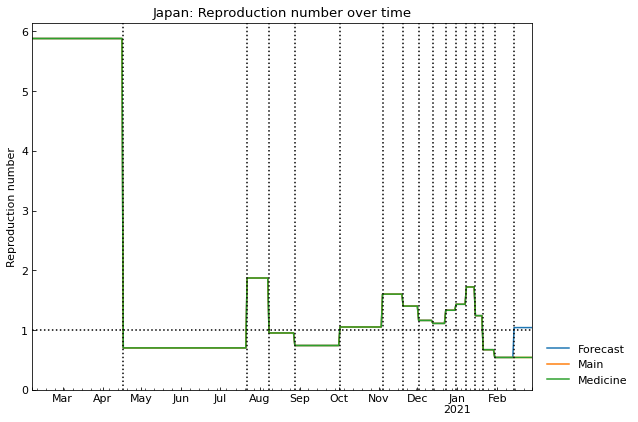

In [31]:
_ = snl.history(target="Rt")

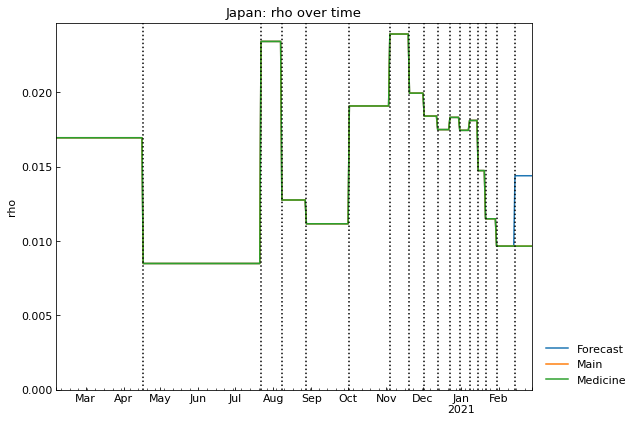

In [32]:
_ = snl.history(target="rho")

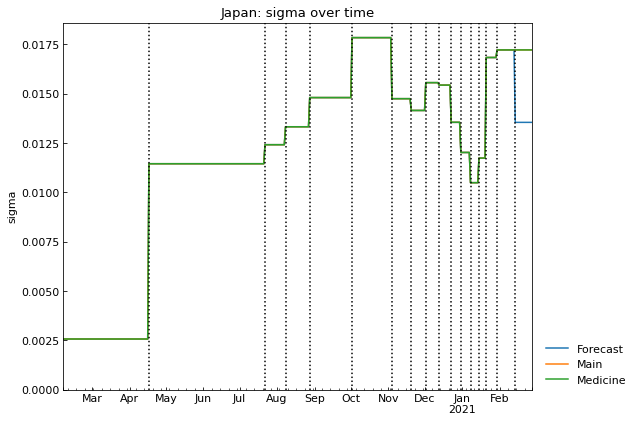

In [33]:
_ = snl.history(target="sigma")

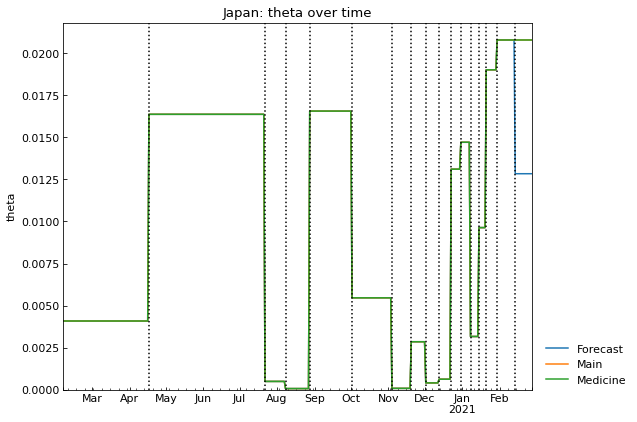

In [34]:
_ = snl.history(target="theta")

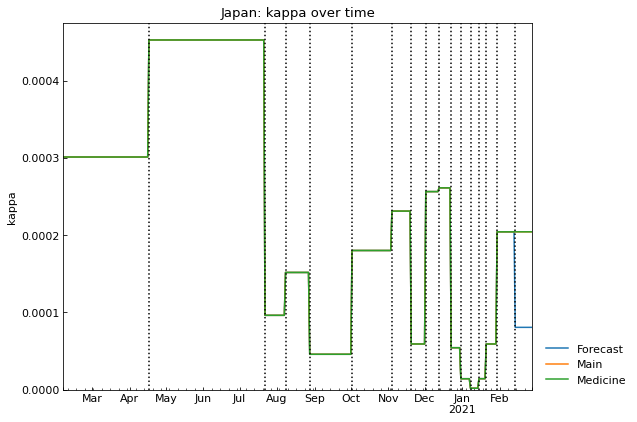

In [35]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

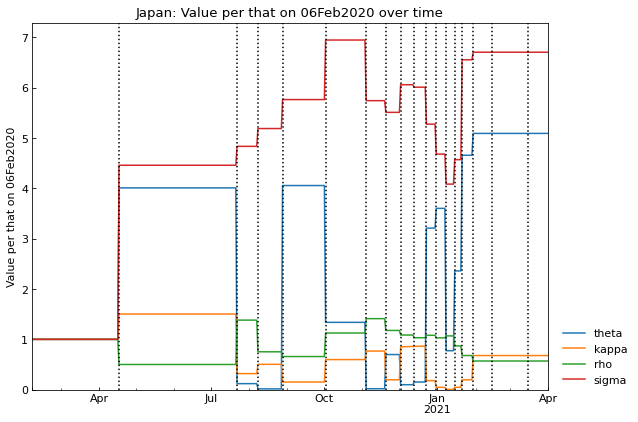

In [36]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [37]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	16th phase (30Jan2021 - 13Feb2021): finished 1208 trials in 1 min  0 sec


	 4th phase (28Aug2020 - 31Aug2020): finished  114 trials in 0 min 10 sec

	 8th phase (20Nov2020 - 01Dec2020): finished  303 trials in 0 min 30 sec

	 0th phase (06Feb2020 - 16Apr2020): finished  477 trials in 0 min 50 sec

	 7th phase (04Nov2020 - 19Nov2020): finished  490 trials in 0 min 50 sec

	 9th phase (02Dec2020 - 12Dec2020): finished  207 trials in 0 min 20 sec

	 5th phase (01Sep2020 - 01Oct2020): finished  641 trials in 1 min 10 sec

	10th phase (13Dec2020 - 22Dec2020): finished  216 trials in 0 min 20 sec

	11th phase (23Dec2020 - 30Dec2020): finished  188 trials in 0 min 20 sec

	 1st phase (17Apr2020 - 21Jul2020): finished  718 trials in 1 min 21 sec

	 3rd phase (08Aug2020 - 27Aug2020): finished  798 trials in 1 min 31 sec

	13th phase (08Jan2021 - 14Jan2021): finished  416 trials in 0 min 40 sec

	14th phase (15Jan2021 - 20Jan2021): finished  415 trials in 0 min 40 sec

	12th phase (31Dec2020 - 07Jan2021): finished  506 trials in 0 min 50 sec

	 6th phase (02Oct2020 - 03Nov2020): finished 1080 trials in 2 min  1 sec

	15th phase (21Jan2021 - 29Jan2021): finished  575 trials in 0 min 50 sec

	 2nd phase (22Jul2020 - 07Aug2020): finished 2017 trials in 3 min  1 sec

Completed optimization. Total: 4 min  3 sec



<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	 5th phase (01Sep2020 - 13Feb2021): finished 1946 trials in 0 min 40 sec

Completed optimization. Total: 0 min 42 sec


In [38]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.78  0.018380  0.000859   
              1st    17Apr2020  21Jul2020  SIR-F  0.60  0.074056  0.000076   
              2nd    22Jul2020  07Aug2020  SIR-F  2.00  0.000173  0.000233   
              3rd    08Aug2020  27Aug2020  SIR-F  0.94  0.000323  0.000743   
              4th    28Aug2020  31Aug2020  SIR-F  0.76  0.000460  0.001847   
              5th    01Sep2020  01Oct2020  SIR-F  0.79  0.000493  0.001355   
              6th    02Oct2020  03Nov2020  SIR-F  1.02  0.000366  0.000906   
              7th    04Nov2020  19Nov2020  SIR-F  1.60  0.000161  0.000772   
              8th    20Nov2020  01Dec2020  SIR-F  1.37  0.001169  0.000948   
              9th    02Dec2020  12Dec2020  SIR-F  1.17  0.000203  0.001434   
              10th   13Dec2020  22Dec2020  SIR-F  1.16  0.000198  0.001442   
              11th   23Dec2020  30Dec2020  SIR-F  1.31  0.000378  0.001661   
              12th   31Dec2020  07Jan2021  SIR-F  1.40  0.004705  0.000751   
              13th   08Jan2021  14Jan2021  SIR-F  1.95  0.000623  0.001127   
              14th   15Jan2021  20Jan2021  SIR-F  1.15  0.000973  0.000535   
              15th   21Jan2021  29Jan2021  SIR-F  0.72  0.018387  0.000188   
              16th   30Jan2021  13Feb2021  SIR-F  0.54  0.031203  0.000354   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.78  0.018380  0.000859   
              1st    17Apr2020  21Jul2020  SIR-F  0.60  0.074056  0.000076   
              2nd    22Jul2020  07Aug2020  SIR-F  2.00  0.000173  0.000233   
              3rd    08Aug2020  27Aug2020  SIR-F  0.94  0.000323  0.000743   
              4th    28Aug2020  31Aug2020  SIR-F  0.76  0.000460  0.001847   
              5th    01Sep2020  13Feb2021  SIR-F  0.76  0.000460  0.001847   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.104496  0.020584  0.265777     477  0 min 50 sec  
              1st    0.039671  0.060757  0.417005     718  1 min 21 sec  
              2nd    0.135358  0.067443  0.026746    2017  3 min  1 sec  
              3rd    0.080686  0.084760  0.038929     798  1 min 31 sec  
              4th    0.081232  0.104469  0.010628     114  0 min 10 sec  
              5th    0.080018  0.099586  0.031989     641  1 min 10 sec  
              6th    0.107323  0.104132  0.034150    1080  2 min  1 sec  
              7th    0.129989  0.080623  0.014556     490  0 min 50 sec  
              8th    0.117940  0.084751  0.031481     303  0 min 30 sec  
              9th    0.106339  0.089135  0.009294     207  0 min 20 sec  
              10th   0.099628  0.084346  0.012314     216  0 min 20 sec  
              11th   0.107954  0.080834  0.007762     188  0 min 20 sec  
              12th   0.097728  0.068572  0.008733     506  0 min 50 sec  
              13th   0.106703  0.053576  0.027459     416  0 min 40 sec  
              14th   0.086659  0.074980  0.015603     415  0 min 40 sec  
              15th   0.068342  0.092855  0.018199     575  0 min 50 sec  
              16th   0.059322  0.106994  0.014460    1208  1 min  0 sec  
Retrospective 0th    0.104496  0.020584  0.265777     477  0 min 50 sec  
              1st    0.039671  0.060757  0.417005     718  1 min 21 sec  
              2nd    0.135358  0.067443  0.026746    2017  3 min  1 sec  
              3rd    0.080686  0.084760  0.038929     798  1 min 31 sec  
              4th    0.081232  0.104469  0.010628     114  0 min 10 sec  
              5th    0.081232  0.104469  1.962326    1946  0 min 40 sec

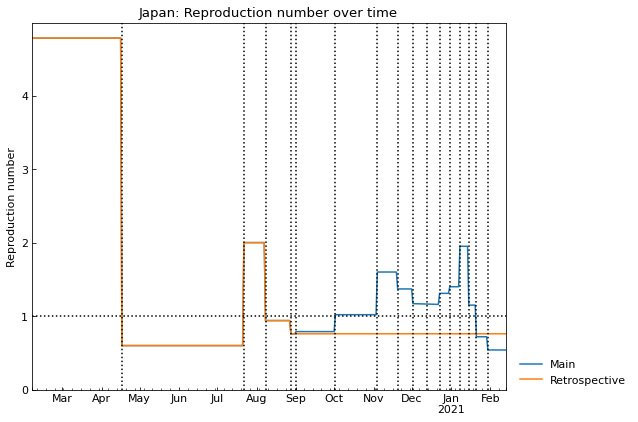

In [39]:
# History of reproduction number
_ = snl_retro.history("Rt")

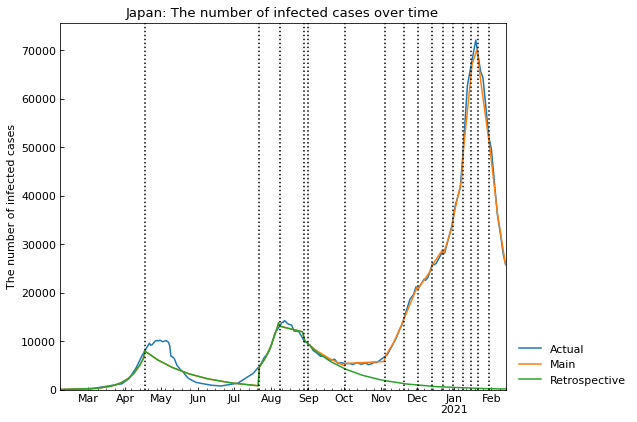

In [40]:
# History of Infected
_ = snl_retro.history("Infected")

In [41]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 14Feb2021,Infected on 14Feb2021,Fatal on 14Feb2021,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt,14th_Rt,15th_Rt,16th_Rt
Main,70131,20Jan2021,415484,24516,6751,0.79,1.02,1.6,1.37,1.17,1.16,1.31,1.4,1.95,1.15,0.72,0.54
Retrospective,13758,07Aug2020,97833,142,1979,0.76,-,-,-,-,-,-,-,-,-,-,-
